In [1]:
import os
import shutil
import pickle
from PIL import Image
from hashlib import sha256
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import models
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator, image

from keras.applications.xception import Xception, decode_predictions
from keras.applications.xception import preprocess_input as preprocess_input_xce

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_input_incV3

from keras.applications.efficientnet import EfficientNetB7
from keras.applications.efficientnet import preprocess_input as preprocess_input_eff

### Variables

In [2]:
PIXELS = 300
path = './images/'
trainList = pd.read_csv('train.csv')
testList = pd.read_csv('test.csv')

## Create directories and copy images

### Create directories

In [3]:
if not os.path.exists('./train'):
    os.mkdir('./train')
if not os.path.exists('./train/cup'):
    os.mkdir('./train/cup')     
if not os.path.exists('./train/fork'):
    os.mkdir('./train/fork')     
if not os.path.exists('./train/glass'):
    os.mkdir('./train/glass')     
if not os.path.exists('./train/knife'):
    os.mkdir('./train/knife')     
if not os.path.exists('./train/plate'):
    os.mkdir('./train/plate')     
if not os.path.exists('./train/spoon'):
    os.mkdir('./train/spoon')     
    
if not os.path.exists('./test'):
    os.mkdir('./test')
    
if not os.path.exists('./Models'):
    os.mkdir('./Models')    

### Copy images to directories

In [ ]:
for img in os.listdir('./images'):
    
    if (not os.path.exists(f'./train/{img}')) and (not(os.path.exists(f'./test/{img}'))):
        imgName = int(img.split('.')[0])
        
        if imgName in trainList.Id.values:
            
            imgLabel = trainList[trainList.Id == imgName].label.values
            
            if imgLabel == 'cup':
                shutil.copy(f'./images/{img}', f'./train/cup/{img}')
            elif imgLabel == 'fork':
                shutil.copy(f'./images/{img}', f'./train/fork/{img}')
            elif imgLabel == 'glass':
                shutil.copy(f'./images/{img}', f'./train/glass/{img}')
            elif imgLabel == 'knife':
                shutil.copy(f'./images/{img}', f'./train/knife/{img}')
            elif imgLabel == 'plate':
                shutil.copy(f'./images/{img}', f'./train/plate/{img}')
            elif imgLabel == 'spoon':
                shutil.copy(f'./images/{img}', f'./train/spoon/{img}')

        else:            
            
            shutil.copy(f'./images/{img}', f'./test/{img}')
            
totalTrainImgs = len(os.listdir("./train/cup")) + len(os.listdir("./train/fork")) + \
                len(os.listdir("./train/glass")) + len(os.listdir("./train/knife")) + \
                len(os.listdir("./train/plate")) + len(os.listdir("./train/spoon"))

totalTestImgs = len(os.listdir("./test"))

print(f'There is a total of {totalTrainImgs} images in the training set')
print(f'There is a total of {totalTestImgs} images in the test set')            

### Image Generators

In [4]:
def ProcInputs(modelName):
    
    preprocessInputs = {'Xception': preprocess_input_xce,
                    'InceptionV3': preprocess_input_incV3,
                    'efficientnetB7': preprocess_input_eff,
                   }
    return preprocessInputs[modelName]


def DataGenerators (modelName, split=0.2):
   
    preprocess_input = ProcInputs(modelName)
    
    dataGenerator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                        validation_split=split,
                                      )    

    trainGenerator = dataGenerator.flow_from_directory(directory='./train',
                                                         batch_size=32,
                                                         target_size=(PIXELS, PIXELS), 
                                                         subset="training",
                                                         shuffle=True,
                                                         class_mode='categorical')

    valGenerator = dataGenerator.flow_from_directory(directory='./train',
                                                       batch_size=16,
                                                       target_size=(PIXELS, PIXELS),
                                                       subset="validation",
                                                       shuffle=True,
                                                       class_mode='categorical')
    
    return trainGenerator, valGenerator

## Testing 3 different models
### Xception, InceptionV3 and EfficientNetB7

### Getting model configurations

In [5]:
def GetModel(modelName):
    
    basemodel_Xce = tf.keras.applications.Xception(weights='imagenet',
                                                   include_top=False,
                                                   input_shape=(PIXELS, PIXELS, 3))

    basemodel_Inc = tf.keras.applications.InceptionV3(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=(PIXELS, PIXELS, 3))
    
    basemodel_EffB7 = tf.keras.applications.EfficientNetB7(weights='imagenet',
                                                       include_top=False,
                                                       input_shape=(PIXELS, PIXELS, 3)) 

   
    basemodels = {'Xception': basemodel_Xce,
                  'InceptionV3': basemodel_Inc,
                  'efficientnetB7': basemodel_EffB7,
                 }
    
    return basemodels[modelName]

### Building the model

In [6]:
def MakeModel(modelName = 'Xception', learning_rate = 0.001, size_inner=128, droprate=0.3):
    
    base_model = GetModel(modelName)
    
    base_model.trainable = False

    inputs = Input(shape=(PIXELS, PIXELS, 3))
    base = base_model(inputs, training=False)
    vectors = layers.GlobalAveragePooling2D()(base)
    
    inner = layers.Dense(size_inner, activation='relu')(vectors)
    drop = layers.Dropout(droprate)(inner)
    
    outputs = layers.Dense(6, activation='softmax')(drop)
    model = Model(inputs, outputs)
    
    optimizer = Adam(learning_rate=learning_rate)
    loss = CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

### Checkpointing

In [7]:
def GetCheckpoint(modelName):
    checkpoint = keras.callbacks.ModelCheckpoint("./Models/" + modelName + '_{epoch:02d}_{val_accuracy:.3f}.h5',
                                                 save_best_only=True,
                                                 #save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max')
    return checkpoint

def GetCheckpointFull(modelName):
    checkpoint = keras.callbacks.ModelCheckpoint("./Models/" + modelName + '_{epoch:02d}_{accuracy:.3f}.h5',
                                                 save_best_only=True,
                                                 #save_weights_only=True,
                                                 monitor='accuracy',
                                                 mode='max')
    return checkpoint


### Model preparation

In [8]:
def RunModel(learningRates, modelName, steps_per_epoch=50, epochs=10):
    
    scores = {}
    size = 128
    droprate = 0.3
    trainGenerator, valGenerator = DataGenerators (modelName)
    print()

    for lr in learningRates:
        print(f'Learning rate: {lr}')
        checkpoint = GetCheckpoint(modelName + '_' + f'lr{lr}')
        model = MakeModel(modelName=modelName, learning_rate=lr)
        history = model.fit(trainGenerator,
                            validation_data=valGenerator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=epochs,
                            callbacks=[checkpoint])
        scores[lr] = history.history
        print('\n')
    
    return model, history, scores

### Plot history

In [9]:
def PlotHistory(scores, lims=[0.9,0.98], xaxis=10):
        
    for lr , hist in scores.items():
        plt.plot(hist['val_accuracy'], label=lr)

    plt.xticks(np.arange(xaxis))
    plt.ylim(lims[0], lims[1])
    plt.legend()

### Finding best Learning rates for models

### Xception

In [10]:
learningRates = [0.0004, 0.0007, 0.001]
modelName = 'Xception'
model_X, history_X, scores_X = RunModel(learningRates, modelName)

Found 4450 images belonging to 6 classes.
Found 1109 images belonging to 6 classes.

Learning rate: 0.0004
Epoch 1/10
50/50 [==============================] - 19s 314ms/step - loss: 0.6452 - accuracy: 0.8261 - val_loss: 0.2266 - val_accuracy: 0.9387


C:\Users\clavi\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
50/50 [==============================] - 14s 290ms/step - loss: 0.2227 - accuracy: 0.9406 - val_loss: 0.1615 - val_accuracy: 0.9513
Epoch 3/10
50/50 [==============================] - 15s 291ms/step - loss: 0.1756 - accuracy: 0.9465 - val_loss: 0.1422 - val_accuracy: 0.9549
Epoch 4/10
50/50 [==============================] - 15s 294ms/step - loss: 0.1463 - accuracy: 0.9500 - val_loss: 0.1304 - val_accuracy: 0.9567
Epoch 5/10
50/50 [==============================] - 14s 290ms/step - loss: 0.1416 - accuracy: 0.9656 - val_loss: 0.1310 - val_accuracy: 0.9567
Epoch 6/10
50/50 [==============================] - 14s 291ms/step - loss: 0.1111 - accuracy: 0.9675 - val_loss: 0.1276 - val_accuracy: 0.9549
Epoch 7/10
50/50 [==============================] - 15s 293ms/step - loss: 0.1284 - accuracy: 0.9594 - val_loss: 0.1576 - val_accuracy: 0.9414
Epoch 8/10
50/50 [==============================] - 14s 290ms/step - loss: 0.1172 - accuracy: 0.9600 - val_loss: 0.1189 - val_accuracy: 0.9594

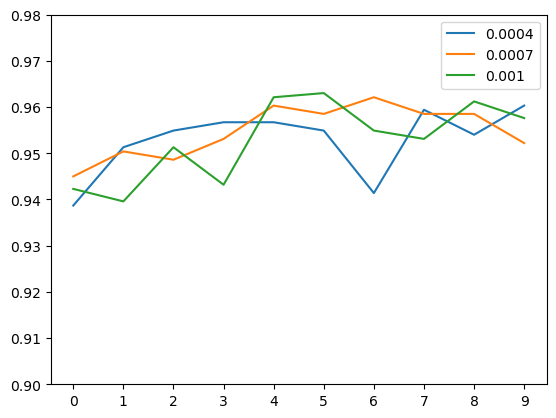

In [11]:
PlotHistory(scores_X, lims=[0.9, 0.98])

### InceptionV3

In [12]:
learningRates = [0.0004, 0.0007, 0.001]
modelName = 'InceptionV3'
model_IN, history_IN, scores_IN = RunModel(learningRates, modelName)

Found 4450 images belonging to 6 classes.
Found 1109 images belonging to 6 classes.

Learning rate: 0.0004
Epoch 1/10
50/50 [==============================] - 20s 330ms/step - loss: 0.6908 - accuracy: 0.7688 - val_loss: 0.3757 - val_accuracy: 0.8674
Epoch 2/10
50/50 [==============================] - 15s 299ms/step - loss: 0.2960 - accuracy: 0.9089 - val_loss: 0.2293 - val_accuracy: 0.9234
Epoch 3/10
50/50 [==============================] - 15s 293ms/step - loss: 0.2283 - accuracy: 0.9287 - val_loss: 0.2141 - val_accuracy: 0.9378
Epoch 4/10
50/50 [==============================] - 15s 294ms/step - loss: 0.2324 - accuracy: 0.9206 - val_loss: 0.1838 - val_accuracy: 0.9432
Epoch 5/10
50/50 [==============================] - 14s 290ms/step - loss: 0.1826 - accuracy: 0.9376 - val_loss: 0.1917 - val_accuracy: 0.9414
Epoch 6/10
50/50 [==============================] - 15s 293ms/step - loss: 0.1682 - accuracy: 0.9444 - val_loss: 0.1717 - val_accuracy: 0.9378
Epoch 7/10
50/50 [=================

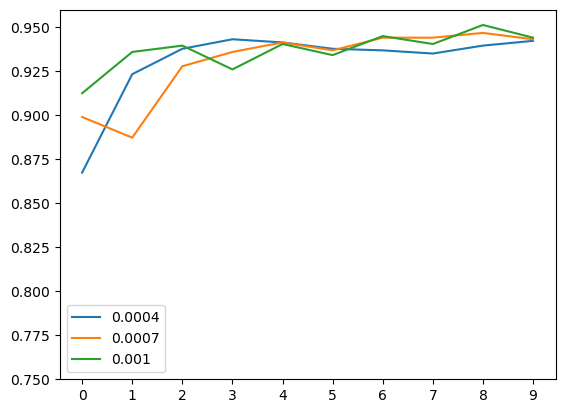

In [13]:
PlotHistory(scores_IN, lims=(0.75, 0.96))

### EfficientnetB7

In [14]:
learningRates = [0.0004, 0.0007, 0.001]
modelName = 'efficientnetB7'
model_EN, history_EN, scores_EN = RunModel(learningRates, modelName)

Found 4450 images belonging to 6 classes.
Found 1109 images belonging to 6 classes.

Learning rate: 0.0004
Epoch 1/10
50/50 [==============================] - 37s 548ms/step - loss: 0.4876 - accuracy: 0.8885 - val_loss: 0.1505 - val_accuracy: 0.9567
Epoch 2/10
50/50 [==============================] - 23s 464ms/step - loss: 0.1341 - accuracy: 0.9594 - val_loss: 0.1183 - val_accuracy: 0.9639
Epoch 3/10
50/50 [==============================] - 23s 465ms/step - loss: 0.1034 - accuracy: 0.9675 - val_loss: 0.1124 - val_accuracy: 0.9630
Epoch 4/10
50/50 [==============================] - 23s 466ms/step - loss: 0.0935 - accuracy: 0.9750 - val_loss: 0.1062 - val_accuracy: 0.9675
Epoch 5/10
50/50 [==============================] - 23s 466ms/step - loss: 0.0801 - accuracy: 0.9800 - val_loss: 0.1085 - val_accuracy: 0.9639
Epoch 6/10
50/50 [==============================] - 23s 465ms/step - loss: 0.0837 - accuracy: 0.9752 - val_loss: 0.1061 - val_accuracy: 0.9612
Epoch 7/10
50/50 [=================

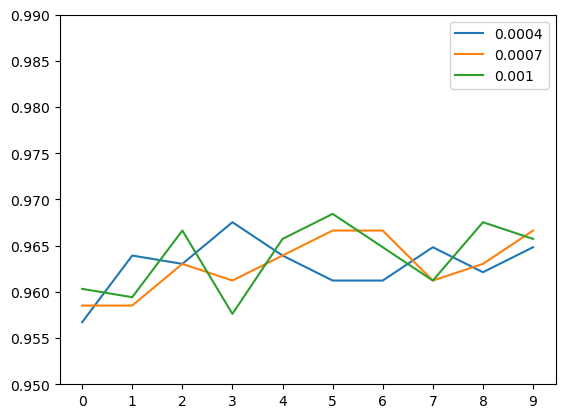

In [15]:
PlotHistory(scores_EN, lims=(0.95,0.99))

## Training the model Xception for longer and then tunning it
#### This one gave us a decent accuracy and it runs faster than EfficientNet

In [ ]:
modelName = 'efficientnetB7'
droprate = 0.3

base_model = GetModel(modelName)
base_model.trainable = False

inputs = Input(shape=(PIXELS, PIXELS, 3))
base = base_model(inputs, training=False)
vectors = layers.GlobalAveragePooling2D()(base)
inner = layers.Dense(128, activation='relu')(vectors)
drop = layers.Dropout(droprate)(inner)
outputs = layers.Dense(6, activation='softmax')(drop)
model = Model(inputs, outputs)

learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)
loss = CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [49]:
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 10, 10, 2560)      64097687  
_________________________________________________________________
global_average_pooling2d_10  (None, 2560)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               327808    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 6)                 774       
Total params: 64,426,269
Trainable params: 328,582
Non-trainable params: 64,097,687
________________________________________

In [50]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  813


In [51]:
len(model.trainable_variables)

4

In [52]:
train, val = DataGenerators (modelName, split=0.2)

Found 4450 images belonging to 6 classes.
Found 1109 images belonging to 6 classes.


In [53]:
loss0, accuracy0 = model.evaluate(val)

70/70 [==============================] - 10s 139ms/step - loss: 0.2070 - accuracy: 0.9522


In [54]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.21
initial accuracy: 0.95


In [55]:
initial_epochs = 10

checkpoint = GetCheckpoint(modelName)
history = model.fit(train,
                    steps_per_epoch=50,
                    epochs=initial_epochs,
                    validation_data=val,
                   callbacks=[checkpoint])

Epoch 1/10
50/50 [==============================] - 23s 467ms/step - loss: 0.0889 - accuracy: 0.9781 - val_loss: 0.1720 - val_accuracy: 0.9612
Epoch 2/10
50/50 [==============================] - 23s 467ms/step - loss: 0.0914 - accuracy: 0.9783 - val_loss: 0.2877 - val_accuracy: 0.9558
Epoch 3/10
50/50 [==============================] - 23s 467ms/step - loss: 0.1425 - accuracy: 0.9681 - val_loss: 0.3787 - val_accuracy: 0.9612
Epoch 4/10
50/50 [==============================] - 24s 482ms/step - loss: 0.0824 - accuracy: 0.9819 - val_loss: 0.3565 - val_accuracy: 0.9567
Epoch 5/10
50/50 [==============================] - 24s 471ms/step - loss: 0.1778 - accuracy: 0.9700 - val_loss: 0.4273 - val_accuracy: 0.9558
Epoch 6/10
50/50 [==============================] - 24s 477ms/step - loss: 0.1603 - accuracy: 0.9650 - val_loss: 0.3503 - val_accuracy: 0.9513
Epoch 7/10
50/50 [==============================] - 24s 480ms/step - loss: 0.1325 - accuracy: 0.9725 - val_loss: 0.2744 - val_accuracy: 0.9594

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [91]:
loss = history.history['loss']
val_loss = history.history['val_loss']

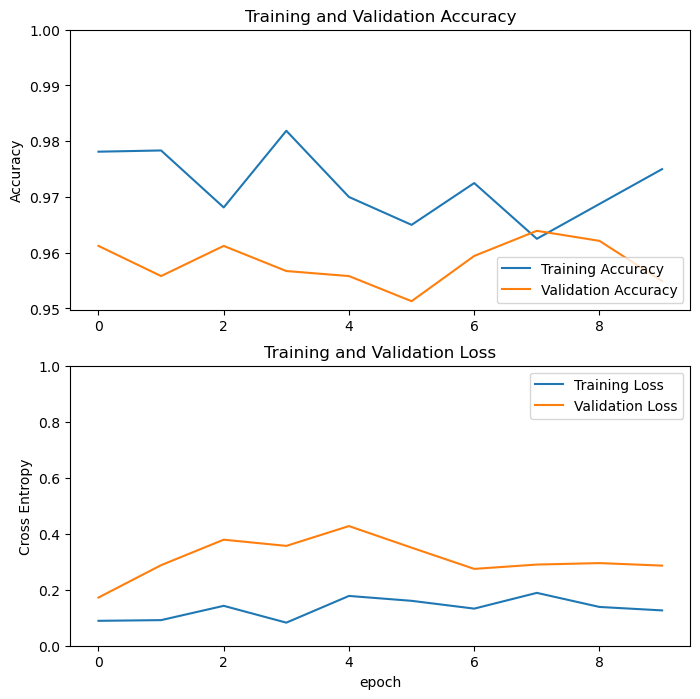

In [58]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


### Tunning the model

In [59]:
base_model.trainable = True
base_model.summary()
#model = old_model


Model: "efficientnetb7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling_10 (Rescaling)        (None, 300, 300, 3)  0           input_43[0][0]                   
__________________________________________________________________________________________________
normalization_10 (Normalization (None, 300, 300, 3)  7           rescaling_10[0][0]               
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization_10[0][0]           
_____________________________________________________________________________________

In [60]:
old_model = model
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))


Number of layers in the base model:  813


In [85]:
base_model.layers[752].name

'block7a_expand_conv'

In [86]:
# Fine-tune from this layer onwards
fine_tune_at = 752

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


In [87]:
learning_rate = 0.001/10
optimizer = Adam(learning_rate=learning_rate)
loss = CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


In [88]:
model.summary()


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 10, 10, 2560)      64097687  
_________________________________________________________________
global_average_pooling2d_10  (None, 2560)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               327808    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 6)                 774       
Total params: 64,426,269
Trainable params: 23,404,998
Non-trainable params: 41,021,271
_____________________________________

In [89]:
len(model.trainable_variables)

59

In [90]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train,
                         epochs=total_epochs,
                         steps_per_epoch=50,
                         initial_epoch=history.epoch[-1],
                         validation_data=val,
                         callbacks=[checkpoint])

Epoch 10/15
50/50 [==============================] - 37s 575ms/step - loss: 0.1320 - accuracy: 0.9669 - val_loss: 0.2158 - val_accuracy: 0.9630
Epoch 11/15
50/50 [==============================] - 26s 528ms/step - loss: 0.0873 - accuracy: 0.9825 - val_loss: 0.2282 - val_accuracy: 0.9657


C:\Users\clavi\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/15
50/50 [==============================] - 26s 530ms/step - loss: 0.1468 - accuracy: 0.9737 - val_loss: 0.1496 - val_accuracy: 0.9522
Epoch 13/15
50/50 [==============================] - 27s 532ms/step - loss: 0.0690 - accuracy: 0.9806 - val_loss: 0.1909 - val_accuracy: 0.9630
Epoch 14/15
50/50 [==============================] - 27s 536ms/step - loss: 0.0482 - accuracy: 0.9850 - val_loss: 0.1816 - val_accuracy: 0.9639
Epoch 15/15
50/50 [==============================] - 27s 531ms/step - loss: 0.0418 - accuracy: 0.9856 - val_loss: 0.2403 - val_accuracy: 0.9720


In [92]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


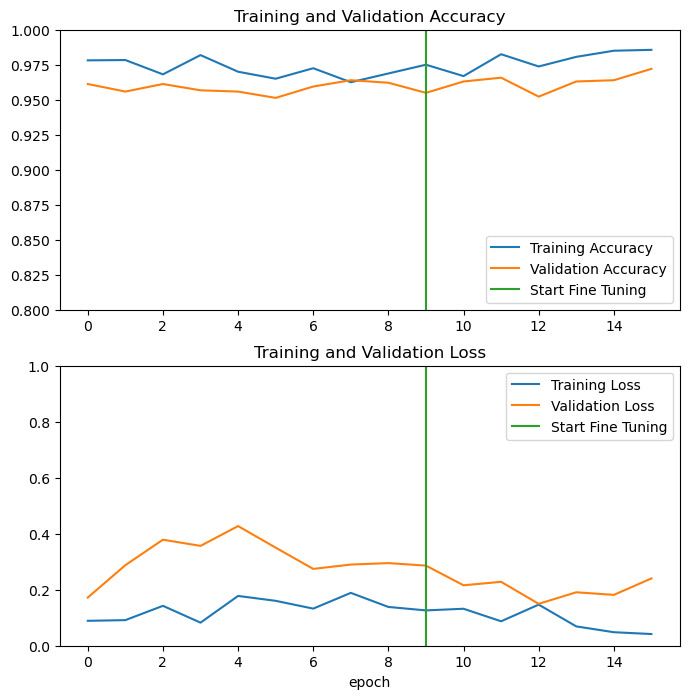

In [93]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
#########################################################

### Predict test labels

In [ ]:
size = 16
droprate = 0.3
modelName = 'Xception'
newModel = model
newModel.load_weights('Xception_32_0.982.h5')

In [ ]:
count =0
res = []
classes = train.class_indices
labels = dict((v, k) for k, v in classes.items())


preprocessInput = ProcInputs(modelName)
    
for file in os.listdir('./test'):
    imgPath = './test/' + file
    img = image.load_img(imgPath, target_size=(PIXELS, PIXELS))
    x = np.array(img)
    X = np.array([x])
    X = preprocessInput(X)
    preds = newModel.predict(X)

    label = labels[np.argmax(preds[0])]
    Id = file.split('.')[0]
    res.append([Id, label])
    if count%400==0:
        print(count, Id, label)
    count += 1

In [ ]:
results = pd.DataFrame(res, columns=['Id', 'label'])
results

results.to_csv('submission_Xception_32_0.982_20xdef+20x10_10th_tunnedExtra.csv', index=False)

In [ ]:
#####################

In [ ]:
count =0
res = []
classes = trainGenerator.class_indices
labels = dict((v, k) for k, v in classes.items())


for file in os.listdir('./test'):
    imgPath = './test/' + file
    img = image.load_img(imgPath, target_size=(PIXELS, PIXELS))
    x = np.array(img)
    X = np.array([x])
    X = preprocess_input_xce(X)
    preds1 = newModel1.predict(X)
    preds2 = newModel2.predict(X)
    #preds3 = newModel3.predict(X)
    #preds4 = newModel4.predict(X)
    preds = preds1 * 0.35 + preds2 * 0.35# + preds3 * 0.2 + preds4 * 0.1 
    
    label = labels[np.argmax(preds[0])]
    Id = file.split('.')[0]
    res.append([Id, label])
    if count%400==0:
        print(count, Id, label)
    count += 1

In [ ]:
results = pd.DataFrame(res, columns=['Id', 'label'])
results

results.to_csv('submission_full_combo.csv', index=False)

In [ ]:
##############################################

### Find duplicated images

In [ ]:
imgHashes = defaultdict(list)

def hashing(image):
    with Image.open(path + image) as f:
            imgHash = sha256(f.tobytes()).hexdigest()
            imgName = image
    return imgHash, imgName

for image in os.listdir(path):
    imgHash, imgName = hashing(image)
    imgHashes[imgHash].append(imgName)            

In [ ]:
duplicated = []
duplicated_train = []

print('All duplicated set of images:')
for h256, imgs in imgHashes.items():
    if len(imgs) >= 2:
        duplicated += imgs
        print(f'{imgs[0]}, {imgs[1]}')
        for img in imgs:
            imgRead = mpimg.imread('images/'+ img)
            imgName = int(img.split('.')[0])
            if imgName in trainList.Id.values:
                duplicated_train.append(str(img))

print(f'\nDuplicated images in train set:\n{", ".join(duplicated_train)}')

### Check duplicated images

In [ ]:
fig, ax = plt.subplots(6,2, figsize=(6, 15))

for img, ax in zip(duplicated, ax.ravel()):
    imgRead = mpimg.imread('images/'+ img)
    ax.imshow(imgRead)
    ax.set_title(img)

fig.tight_layout()

### Flip duplicated images only on the train set

In [ ]:
images_to_flip = ['0237.jpg', '6833.jpg', '7063.jpg']

for img in images_to_flip:
    print(img)
    imgName = path + img 
    print(imgName)
    image = Image.open(path + img)
    print(image)
    img_rotated = image.transpose(method=Image.Transpose.FLIP_LEFT_RIGHT)
    img_rotated.save(path + img )

### Verify images have been flipped

In [ ]:
fig2, ax2 = plt.subplots(6,2, figsize=(6, 15))

for img, ax in zip(duplicated, ax2.ravel()):
    imgRead = mpimg.imread('images/'+ img)
    ax.imshow(imgRead)
    ax.set_title(img)

fig.tight_layout()